In [ ]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
from scipy.integrate import quad
import skfda
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
import torch
import torch.nn as nndata
import torch.optim as optim
from models import *
from data_generation_new import *
from utils import *
from training import *

In [ ]:
## Data generation
J = 5
d = 10000
sigma1 = np.repeat(1,J)
theta1 = np.diag(np.repeat(0.8,J))
X_coef,Z_coef = generate_ma1(J = J, d = d, sigma = sigma1, theta = theta1)
print(X_coef.shape)

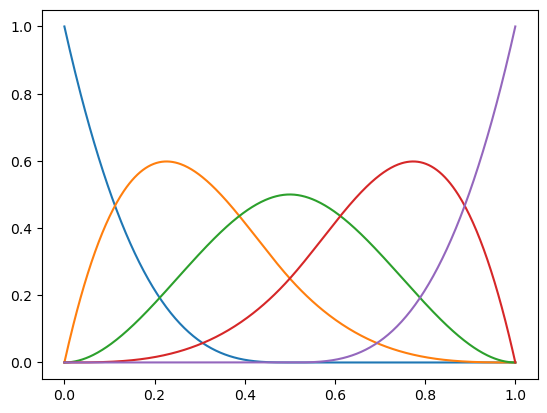

[0.26726124 0.33273756 0.3047247  0.33273756 0.26726124]


In [6]:
Bbasis = BSplineBasis(domain_range=(0, 1), n_basis=J)
Bbasis.plot()
plt.show()

G = Bbasis.gram_matrix()
norms = np.sqrt(np.diag(G))
print(norms)


So the bspline basis right now is not normalized, we times diag(1/n1,1/n2,....,1/nJ) to make it an normalized one.

$[b_1,b_2,\cdots,b_J]$ is the original bspline space.
$[\tilde{b}_1,\tilde{b}_2,\cdots,\tilde{b}_J] = diag(1/n1,1/n2,....,1/nJ) \times [b_1,b_2,\cdots,b_J]^T$ is the original bspline space.

In [7]:
bspline_norm_basis = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= np.diag(1/norms)  # X_coef: coefficient on 
)
# check if times diag(1/n1,1/n2,...,1/nJ), whether the norm would be all 1.
norm_values = np.sqrt(np.sum(bspline_norm_basis.coefficients @ G * bspline_norm_basis.coefficients, axis=1))

print(norm_values)

[1. 1. 1. 1. 1.]


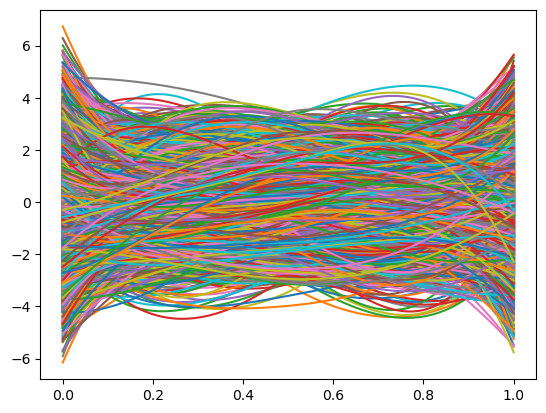

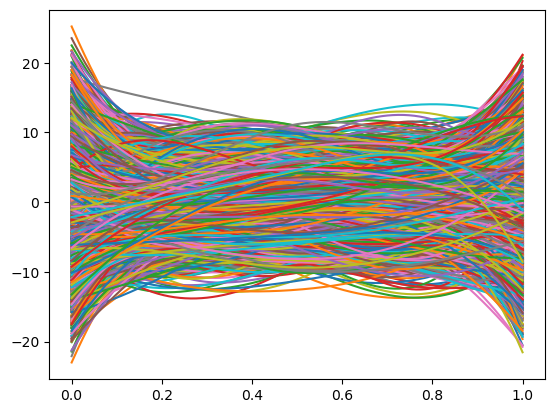

In [8]:
fd_basis1 = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= X_coef   
)
fd_basis1.plot()
plt.show()

fd_basis2 = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= X_coef@ np.diag(1/norms)
)
fd_basis2.plot()
plt.show()

In [9]:
fpca = FPCA(n_components=5)
fpca.fit(fd_basis1)
scores = fpca.transform(fd_basis1)

fpca_tilde = FPCA(n_components=5)
fpca_tilde.fit(fd_basis2)
scores_tilde = fpca_tilde.transform(fd_basis2)
# Explained variance ratio
print("Explained variance by each PC:", fpca.explained_variance_ratio_)
print(sum(fpca.explained_variance_ratio_))
print("Explained variance by each PC:", fpca_tilde.explained_variance_ratio_)
print(sum(fpca_tilde.explained_variance_ratio_))

Explained variance by each PC: [0.49711837 0.26527726 0.14403746 0.07724085 0.01632606]
0.9999999999999999
Explained variance by each PC: [0.45680221 0.2729644  0.17578605 0.07933374 0.0151136 ]
1.0


In [10]:
E_coef = fpca_tilde.components_.coefficients 
E_coef_tilde2 = fpca.components_.coefficients 

In [11]:
scores.shape

(10000, 5)

In [12]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: Bbasis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [13]:
Y_np.shape

(10000,)

In [14]:
X = torch.tensor(scores.T, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(1, d)
print(Y.size())

torch.Size([5, 10000])
torch.Size([1, 10000])


# Model adding covariates

In [15]:
trunc_q = d-1
m = d**(1/3)
print(m)
q = 4

21.544346900318832


In [ ]:
weight_net = WeightNetwork(input_dim=1, m_init=m, q_init=q)
model = Model1_MHA(X.shape[0], X.shape[1], X.shape[1], 32, Y.shape[0], Y.shape[1], weight_net, trunc_q)

trained_model, trained_weight_net, best_cov_matrix = train_model(
    X, Y, weight_net, model, LR_cov_X
)

/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)
/Users/xinyiwang/Desktop/UCDavis/research_alex/long-run-covariance/codes/models.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_matrix[i, j] = torch.tensor(torch.sum(weighted_cross_cov), dtype=X.dtype, device=X.device)
/Users/xinyiwang/Desktop/UCDavis/research_alex/long-run-covariance/codes/models.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_matrix_w1[i, j] = torch.tensor(to

Epoch [200/10000], Loss: 9.0652
Epoch [400/10000], Loss: 1.7054
Epoch [600/10000], Loss: 2.2533
Epoch [800/10000], Loss: 1.9543
Epoch [1000/10000], Loss: 10.2693
Epoch [1200/10000], Loss: 50.8643
Early stopping at Epoch [1241/10000] - No improvement for 700 epochs.

Restoring best model and weight network...


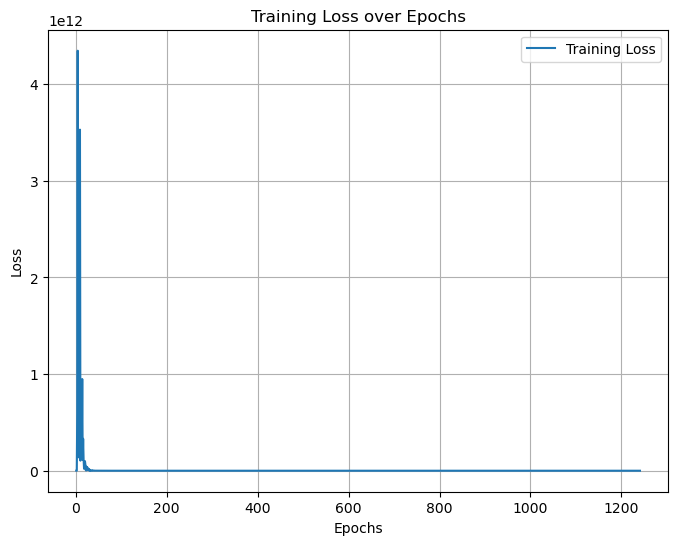

In [16]:
# Define the weight network and the main model
weight_net = WeightNetwork(input_dim=1, m_init = m, q_init = q)  # Neural network to estimate weights

x_shape_0 = X.shape[0]
x_shape_1 = X.shape[1]
hidden_dim = 32  # Example hidden layer size
y_shape_0 = Y.shape[0]
y_shape_1 = Y.shape[1]  
cov_dim = x_shape_0

model = Model1_MHA(
    X.shape[0], X.shape[1], X.shape[1], hidden_dim, Y.shape[0], Y.shape[1], weight_net, trunc_q
)
criterion = nn.MSELoss()
optimizer = optim.Adam(list(model.parameters()) + list(weight_net.parameters()), lr=0.02)


# Initialize tracking for best model
best_loss = float('inf')
best_model_state = None
best_weight_net_state = None
best_cov_matrix = None
patience = 700
wait = 0

epochs = 10000
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Recompute covariance matrix with updated weights
    cov_matrix, cov_matrix_w1, cov_matrix3 = LR_cov_X(X, weight_net, trunc_q)
    
    Y_hat = model(X)  # Predicted Y(t)
    
    loss = criterion(Y_hat, Y)  # Compute L2 loss
    loss.backward()
    
#     for name, param in weight_net.named_parameters():
#         if param.grad is not None:
#             print(f"Gradient for {name}: {param.grad.norm().item()}")
#         else:
#             print(f"No gradient for {name}")
              
    optimizer.step()
    
    losses.append(loss.item())
#     print(f"Epoch = {epoch}, model.weight_net.h = {torch.exp(model.weight_net.h_param)}")

    # Check if the loss is sufficiently small
    if abs(loss.item()) < 1e-4:
        print(f"Stopping early at Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
        break  # Exit loop when loss is small enough

    # Save the best model and covariance matrix
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state = model.state_dict()  # Save model state
        best_weight_net_state = weight_net.state_dict()  # Save weight_net state
        best_cov_matrix = cov_matrix.clone()  # Save best covariance matrix
        wait = 0  # Reset patience counter
    else:
        wait += 1  # Increment patience counter if loss does not improve

    if wait >= patience:
        print(f"Early stopping at Epoch [{epoch+1}/{epochs}] - No improvement for {patience} epochs.")
        break  # Stop training if no improvement for `patience` epochs

    # Print loss every 20 epochs
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Restore the best model and weight network
print("\nRestoring best model and weight network...")
model.load_state_dict(best_model_state)
weight_net.load_state_dict(best_weight_net_state)

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()
# raise ValueError("stop at here")


Shape of Covariance Matrix (NumPy): (5, 5)


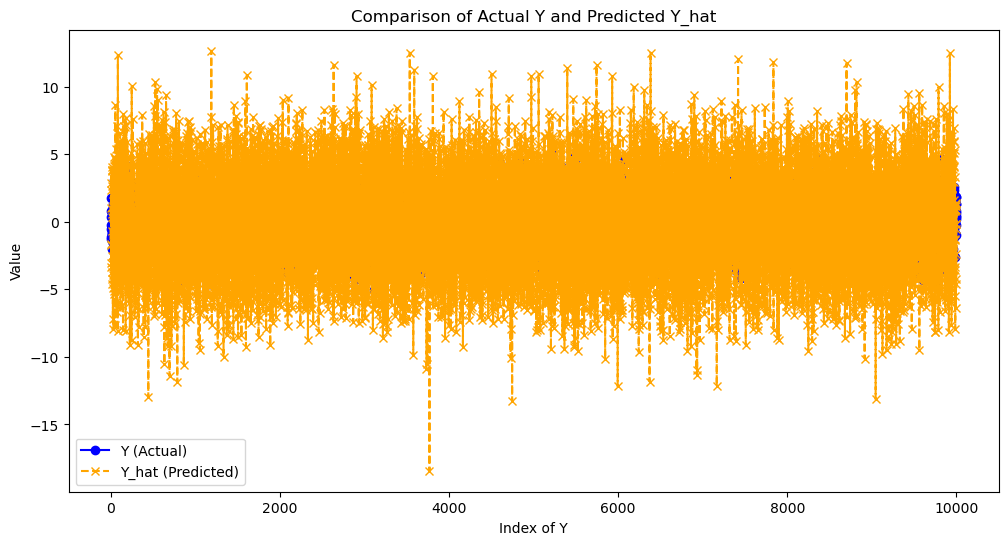

In [17]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_matrix, cov_matrix_w1, cov_matrix3 = LR_cov_X(X, weight_net, trunc_q)
    cov_matrix_np = cov_matrix.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_matrix_np.shape)

    Y_hat = model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


In [18]:
cov_matrix

tensor([[ 5.2438e+00,  2.6019e-01,  1.4342e-01,  5.2624e-02, -9.4405e-02],
        [ 2.5524e-02,  2.8581e+00, -1.0153e-01,  8.9288e-02,  1.9057e-02],
        [ 2.3270e-02, -1.6036e-01,  1.7288e+00, -1.1470e-01, -2.7999e-02],
        [ 2.7709e-02, -1.2613e-01, -4.0669e-02,  9.2786e-01,  7.1970e-03],
        [-5.1439e-02, -3.3116e-02,  2.1682e-04,  2.1453e-02,  1.7972e-01]])

In [19]:
import os
import pandas as pd
# Ensure the results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

csv_path = os.path.join(results_dir, f"cov_matrix_case1_FMA_{d}_MHA.csv")

# Convert matrices to DataFrames
df1 = pd.DataFrame(cov_matrix)
df2 = pd.DataFrame(cov_matrix_w1)
df3 = pd.DataFrame(cov_matrix3)

# Save matrices to CSV with an empty line between them
with open(csv_path, 'w', newline='') as f:
    df1.to_csv(f, index=False, header=False)
    f.write("\n")  # Write an empty line
    df2.to_csv(f, index=False, header=False)
    f.write("\n")  # Write another empty line
    df3.to_csv(f, index=False, header=False)

print(f"Saved matrices to {csv_path} with empty lines between them.")

Saved matrices to results/cov_matrix_case1_FMA_10000_MHA.csv with empty lines between them.


# Compute true covariance matrix

In [20]:
theoretical_cov_true = np.diag([3.24] * 5)

print(theoretical_cov_true)

[[3.24 0.   0.   0.   0.  ]
 [0.   3.24 0.   0.   0.  ]
 [0.   0.   3.24 0.   0.  ]
 [0.   0.   0.   3.24 0.  ]
 [0.   0.   0.   0.   3.24]]


In [21]:
coefsE_on_btilde = E_coef_tilde2@ np.diag(norms)

In [22]:
G_tilde = np.diag(1/norms) @ G @ np.diag(1/norms)

In [23]:
hat_C = np.zeros((5, 5))

for l in range(5):
    for lp in range(5):
        sum1 = np.sum([coefsE_on_btilde[l, k] * G_tilde[:, k] for k in range(5)], axis=0)
        sum2 = np.sum([coefsE_on_btilde[lp, k] * G_tilde[:, k] for k in range(5)], axis=0)
        hat_C[l, lp] = np.sum([theoretical_cov_true[i, j] * sum1[i] * sum2[j] for i in range(5) for j in range(5)])
#print(np.round(hat_C,4))

In [24]:
np.trace(hat_C)

np.float64(16.200000000000006)

In [25]:
print(np.linalg.eigvals(hat_C))
sum(np.linalg.eigvals(hat_C))

[7.36592291 4.47792876 2.83844442 0.24724557 1.27045834]


np.float64(16.200000000000014)

In [26]:
np.round(hat_C,4)

array([[ 7.3401, -0.0297,  0.3216,  0.06  , -0.1055],
       [-0.0297,  4.3778,  0.0091, -0.5587, -0.0074],
       [ 0.3216,  0.0091,  2.8546,  0.1003, -0.0551],
       [ 0.06  , -0.5587,  0.1003,  1.3776, -0.013 ],
       [-0.1055, -0.0074, -0.0551, -0.013 ,  0.2499]])

In [27]:
cov_matrix

tensor([[ 5.2438e+00,  2.6019e-01,  1.4342e-01,  5.2624e-02, -9.4405e-02],
        [ 2.5524e-02,  2.8581e+00, -1.0153e-01,  8.9288e-02,  1.9057e-02],
        [ 2.3270e-02, -1.6036e-01,  1.7288e+00, -1.1470e-01, -2.7999e-02],
        [ 2.7709e-02, -1.2613e-01, -4.0669e-02,  9.2786e-01,  7.1970e-03],
        [-5.1439e-02, -3.3116e-02,  2.1682e-04,  2.1453e-02,  1.7972e-01]])

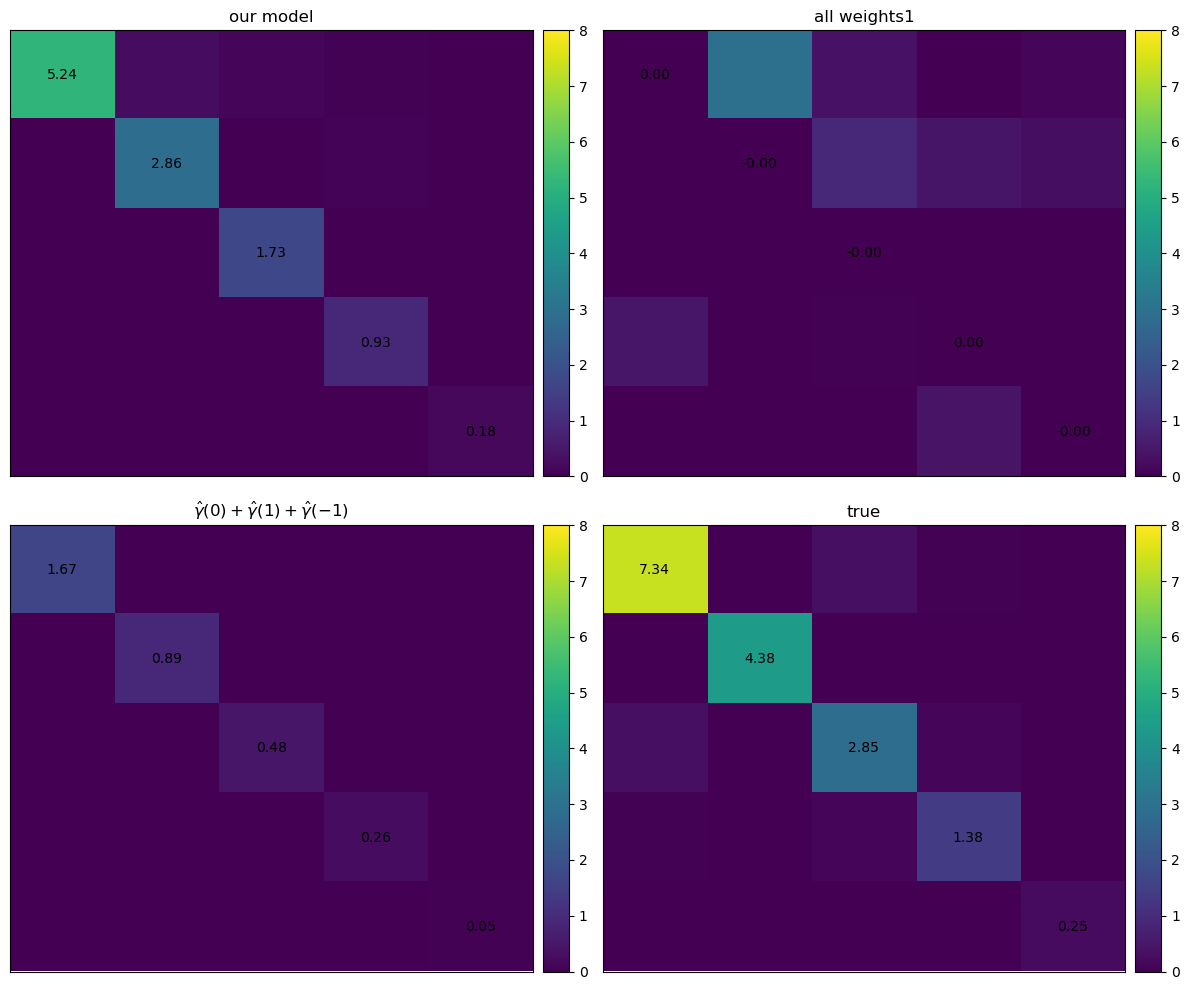

In [28]:
fig = plot_matrices_2d([cov_matrix,cov_matrix_w1, cov_matrix3, hat_C], titles = ["our model", "all weights1", r"$\hat{\gamma}(0) + \hat{\gamma}(1) + \hat{\gamma}(-1)$", "true"])

In [29]:
filename = f"figures/matrix3d_compare{d}_truc{trunc_q}_bd{round(m)}_MHA.png"
fig.savefig(filename, dpi=300, bbox_inches='tight')
plt.close(fig)  # Close the figure to free memory

print(f"Plot saved as {filename}")

Plot saved as figures/matrix3d_compare10000_truc9999_bd22_MHA.png


In [30]:
print(range(5))

range(0, 5)


In [31]:
print("Sum of diagonal (cov_matrix):", torch.trace(cov_matrix))
print("Sum of diagonal (cov_matrix_w1):", torch.trace(cov_matrix_w1))
print("Sum of diagonal (cov_matrix3):", torch.trace(cov_matrix3))
print("Sum of diagonal (hat_C):", np.trace(hat_C))

Sum of diagonal (cov_matrix): tensor(10.9383)
Sum of diagonal (cov_matrix_w1): tensor(-4.3306e-08)
Sum of diagonal (cov_matrix3): tensor(3.3651)
Sum of diagonal (hat_C): 16.200000000000006


In [32]:
gamma_list = np.zeros(5)
for i in range(5):
    score_i = scores[:,i]
    cross_cov = ccovf(score_i, score_i, adjusted=False, demean=True, fft=True)
    print(f"for i = {i}, gamma(0) = {cross_cov[0]}, gamma(1) = {cross_cov[1]}")
    gamma_list[i] = sum(cross_cov)

for i = 0, gamma(0) = 0.641465900531822, gamma(1) = 0.5157025443401034
for i = 1, gamma(0) = 0.3423054242065783, gamma(1) = 0.27518903153247376
for i = 2, gamma(0) = 0.1858614092124975, gamma(1) = 0.1495032448124781
for i = 3, gamma(0) = 0.09966916368729499, gamma(1) = 0.08006560135552965
for i = 4, gamma(0) = 0.021066634691005667, gamma(1) = 0.016886872946620436


In [33]:
gamma_list

array([0.32073295, 0.17115271, 0.0929307 , 0.04983458, 0.01053332])